In [1]:
from keras.applications.mobilenet import MobileNet, preprocess_input


image_shape = (128, 128, 3)

features_extractor = MobileNet(include_top=False, input_shape=image_shape)

Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.wrappers import TimeDistributed


def get_model(extractor, nb_classes=12, nb_frames=12, image_shape=(128, 128, 3), summary=False):
    model = Sequential()
    
    model.add(TimeDistributed(extractor, input_shape=(nb_frames, *image_shape)))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(256, return_sequences=False, dropout=0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))    
    
    model.layers[0].trainable = False
    
    if summary:
        print(model.summary())
        
    return model


model = get_model(features_extractor, image_shape=image_shape, summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 12, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 16384)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               17040384  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 12)                6156      
Total params: 20,406,988
Trainable params: 17,178,124
Non-trainable params: 3,228,864
_________________________________________________________________
None


In [7]:
from keras.optimizers import SGD


model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.001), 
              metrics=['acc'])

In [8]:
import random
import os
from functools import reduce

import cv2
import numpy as np
from keras.utils import to_categorical


def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

def read_video(video_path, size=(128, 128, 3)):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    frames = []
    
    while ret:
        if frame.shape != size:
            frame = cv2.resize(frame, (size[1], size[0]))
        frames.append(frame)
        ret, frame = cap.read()
        
    return frames

def preprocess(video_path, nb_frames=12, size=(128, 128, 3)):
    video = []
    
    for frame in read_video(video_path, size=size):
        frame = preprocess_input(frame.astype(np.float64))
        video.append(frame)
        
    video = [frame for frame in video[::len(video)//nb_frames]]
    
    while len(video) < nb_frames:
        video.append(np.zeros(size))

    return np.array(video[:nb_frames])
    
def generator(features, labels, batch_size, size=(128, 128, 3)):
    batch_features = np.zeros((batch_size, 12, 128, 128, 3))
    batch_labels = np.zeros((batch_size, len(labels)))
    
    random.shuffle(features)
    index = 0
    
    def pick(features):
        nonlocal index
        if index == len(features):
            random.shuffle(features)
            index = 0
        feature = features[index]
        index += 1
        return feature

    while True:
        for i in range(batch_size):
            feature, label = pick(features)
            batch_features[i] = preprocess(feature, size=size)
            batch_labels[i] = labels[label]

        yield batch_features, batch_labels

def load(dataset_path):
    videos_path = []

    for root, subdir, filesname in os.walk(dataset_path):
        for filename in filesname:
            if '.mp4' in filename:
                videos_path.append(os.path.join(root, filename))

    _class = ['agosto', 'avisar', 'avisar-me', 'branco', 'educado', 'entender', 
              'entender-não', 'esquecer', 'pessoa', 'quente', 'rápido', 'sentimento']

    features = []
    labels = to_categorical(range(12))

    for i, c in enumerate(_class):
        for path in videos_path:
            if c + '/' in path:
                features.append((path, i))
    
    return features, labels


dataset_path = 'dataset/training'
batch_size = 4
features, labels = load(dataset_path)
gen = generator(features, labels, batch_size)

In [13]:
# debugar se esta gerando corretamenta as imagens
import matplotlib.pyplot as plt
import cv2


batch, label = next(gen)
print(batch.shape, label.shape)

img = np.concatenate([interval_mapping(img, np.min(img), np.max(img), 0, 255).astype(np.uint8)
                for img in batch[0]], axis=1)

plt.figure(figsize=(80,40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

(4, 12, 128, 128, 3) (4, 12)


In [10]:
# first test
history = model.fit_generator(gen, steps_per_epoch=len(features)/batch_size, epochs=10) # test-only

Epoch 1/10
1613/1612 [==============================] - 563s 349ms/step - loss: 2.1882 - acc: 0.2257
Epoch 2/10
1613/1612 [==============================] - 561s 348ms/step - loss: 1.5695 - acc: 0.4405
Epoch 3/10
1613/1612 [==============================] - 560s 347ms/step - loss: 1.1912 - acc: 0.5635
Epoch 4/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.9761 - acc: 0.6303
Epoch 5/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.8422 - acc: 0.6835
Epoch 6/10
1613/1612 [==============================] - 560s 347ms/step - loss: 0.7449 - acc: 0.7170
Epoch 7/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.6543 - acc: 0.7557
Epoch 8/10
1613/1612 [==============================] - 560s 347ms/step - loss: 0.5824 - acc: 0.7852
Epoch 9/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.5294 - acc: 0.8035
Epoch 10/10
1613/1612 [==============================] - 570s 354ms/step - loss: 0.4847 - a

In [11]:
model.save_weights('weights.hdf5')

In [44]:
_class = np.array(['agosto', 'avisar', 'avisar-me', 'branco', 'educado', 'entender', 
          'entender-não', 'esquecer', 'pessoa', 'quente', 'rápido', 'sentimento'])

batch, label = next(gen)
predict = model.predict(batch)

print('predict', _class[np.argmax(predict, axis=1)])
print('labels ', _class[np.argmax(label, axis=1)])

predict ['avisar-me' 'entender-não' 'avisar-me' 'agosto']
labels  ['avisar-me' 'entender' 'avisar-me' 'sentimento']


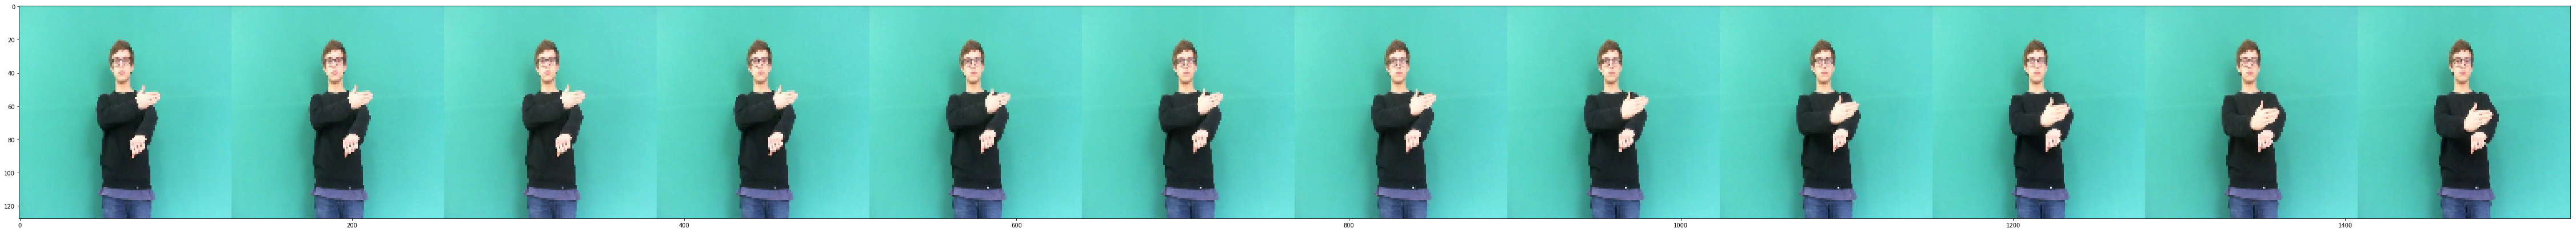

In [43]:
img = np.concatenate([interval_mapping(img, np.min(img), np.max(img), 0, 255).astype(np.uint8)
                for img in batch[0]], axis=1)

plt.figure(figsize=(80,40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
# carrega os dados de validacao
validation_dataset_path = 'dataset/validation'
vfeatures, vlabels = load(validation_dataset_path)
validation_gen = generator(vfeatures, vlabels, batch_size)

In [46]:
print(len(vfeatures))

vret = model.evaluate_generator(validation_gen, steps=len(vfeatures))

print(vret) # loss, acc

1080
[2.4171602539442203, 0.26319444444444445]


# Log

### LSTM(256) -> Dense(512) -> Dense(12)

#### Um voluntario, uma camera, >90%

#### SGD(0.001), Doze voluntarios, cam8, 97.63%, 8 frames
```
Epoch 1/10
717/717 [==============================] - 80s 112ms/step - loss: 2.3100 - acc: 0.2092
Epoch 2/10
717/717 [==============================] - 63s 88ms/step - loss: 1.7178 - acc: 0.4533
Epoch 3/10
717/717 [==============================] - 63s 87ms/step - loss: 1.2424 - acc: 0.6318
Epoch 4/10
717/717 [==============================] - 63s 87ms/step - loss: 0.9182 - acc: 0.7378
Epoch 5/10
717/717 [==============================] - 62s 87ms/step - loss: 0.6590 - acc: 0.8243
Epoch 6/10
717/717 [==============================] - 62s 87ms/step - loss: 0.4894 - acc: 0.8926
Epoch 7/10
717/717 [==============================] - 62s 87ms/step - loss: 0.3579 - acc: 0.9331
Epoch 8/10
717/717 [==============================] - 62s 87ms/step - loss: 0.2697 - acc: 0.9540
Epoch 9/10
717/717 [==============================] - 62s 86ms/step - loss: 0.2101 - acc: 0.9609
Epoch 10/10
717/717 [==============================] - 62s 87ms/step - loss: 0.1690 - acc: 0.9763
```

#### SGD, Doze voluntarios, cam[3,8], training[99.93%], validation[45,83%], 8 frames => overfitting

Provavelmente estava refinando dos treinos anteriores

```
Epoch 1/10
1435/1435 [==============================] - 135s 94ms/step - loss: 0.7159 - acc: 0.7624
Epoch 2/10
1435/1435 [==============================] - 124s 86ms/step - loss: 0.4075 - acc: 0.8850
Epoch 3/10
1435/1435 [==============================] - 127s 89ms/step - loss: 0.2650 - acc: 0.9345
Epoch 4/10
1435/1435 [==============================] - 125s 87ms/step - loss: 0.1867 - acc: 0.9547
Epoch 5/10
1435/1435 [==============================] - 133s 93ms/step - loss: 0.1240 - acc: 0.9770
Epoch 6/10
1435/1435 [==============================] - 127s 88ms/step - loss: 0.0961 - acc: 0.9868
Epoch 7/10
1435/1435 [==============================] - 127s 89ms/step - loss: 0.0815 - acc: 0.9895
Epoch 8/10
1435/1435 [==============================] - 125s 87ms/step - loss: 0.0640 - acc: 0.9958
Epoch 9/10
1435/1435 [==============================] - 127s 89ms/step - loss: 0.0590 - acc: 0.9951
Epoch 10/10
1435/1435 [==============================] - 125s 87ms/step - loss: 0.0344 - acc: 0.9993
```

#### SGD, Doze voluntarios, cam[all], training[99.58%], validation[38.70%], 8 frames

```
Epoch 1/10
6451/6451 [==============================] - 623s 97ms/step - loss: 0.8525 - acc: 0.6800
Epoch 2/10
6451/6451 [==============================] - 573s 89ms/step - loss: 0.3967 - acc: 0.8613
Epoch 3/10
6451/6451 [==============================] - 589s 91ms/step - loss: 0.2715 - acc: 0.9054
Epoch 4/10
6451/6451 [==============================] - 563s 87ms/step - loss: 0.1727 - acc: 0.9443
Epoch 5/10
6451/6451 [==============================] - 608s 94ms/step - loss: 0.1247 - acc: 0.9630
Epoch 6/10
6451/6451 [==============================] - 579s 90ms/step - loss: 0.0860 - acc: 0.9760
Epoch 7/10
6451/6451 [==============================] - 570s 88ms/step - loss: 0.0670 - acc: 0.9833
Epoch 8/10
6451/6451 [==============================] - 575s 89ms/step - loss: 0.0460 - acc: 0.9882
Epoch 9/10
6451/6451 [==============================] - 571s 89ms/step - loss: 0.0389 - acc: 0.9930
Epoch 10/10
6451/6451 [==============================] - 574s 89ms/step - loss: 0.0288 - acc: 0.9958
```

#### Adam, Dropout(0.5), All, training[<10%], 12 frames

```
Epoch 1/15
6451/6451 [==============================] - 789s 122ms/step - loss: 2.5006 - acc: 0.0758
Epoch 2/15
6451/6451 [==============================] - 776s 120ms/step - loss: 2.4932 - acc: 0.0809
Epoch 3/15
6451/6451 [==============================] - 775s 120ms/step - loss: 2.4878 - acc: 0.0837
Epoch 4/15
6451/6451 [==============================] - 777s 120ms/step - loss: 2.4870 - acc: 0.0815
Epoch 5/15
6451/6451 [==============================] - 778s 121ms/step - loss: 2.4857 - acc: 0.0882
Epoch 6/15
6451/6451 [==============================] - 775s 120ms/step - loss: 2.4850 - acc: 0.0873
Epoch 7/15
6451/6451 [==============================] - 784s 121ms/step - loss: 2.4852 - acc: 0.0862
Epoch 8/15
6451/6451 [==============================] - 786s 122ms/step - loss: 2.4849 - acc: 0.0842
Epoch 9/15
 448/6451 [=>............................] - ETA: 12:22 - loss: 2.4856 - acc: 0.0714
```

#### 12 frames, from-scratch, SGD, Dropout[LSTM=0.25], All, training[82.63%], validation[26,31%] porem dobrou a quantidade de exemplos

```
Epoch 1/10
1613/1612 [==============================] - 563s 349ms/step - loss: 2.1882 - acc: 0.2257
Epoch 2/10
1613/1612 [==============================] - 561s 348ms/step - loss: 1.5695 - acc: 0.4405
Epoch 3/10
1613/1612 [==============================] - 560s 347ms/step - loss: 1.1912 - acc: 0.5635
Epoch 4/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.9761 - acc: 0.6303
Epoch 5/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.8422 - acc: 0.6835
Epoch 6/10
1613/1612 [==============================] - 560s 347ms/step - loss: 0.7449 - acc: 0.7170
Epoch 7/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.6543 - acc: 0.7557
Epoch 8/10
1613/1612 [==============================] - 560s 347ms/step - loss: 0.5824 - acc: 0.7852
Epoch 9/10
1613/1612 [==============================] - 561s 348ms/step - loss: 0.5294 - acc: 0.8035
Epoch 10/10
1613/1612 [==============================] - 570s 354ms/step - loss: 0.4847 - acc: 0.8263
```